In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid') 
sns.set_palette('pastel')  

import warnings
warnings.simplefilter("ignore")

In [95]:
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('fraudTest.csv', index_col='Unnamed: 0')

KeyboardInterrupt: 

# Step1. Exploratory Data Analysis

In [ ]:
train_df.head(3)
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

(1296675, 22)

In [ ]:
is_fraud=train_df['is_fraud'].value_counts()
print("Yes: ",is_fraud[1])
print("No: ", is_fraud[0])

Yes:  7506
No:  1289169


In [ ]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


No null and duplicated values in the training dataset

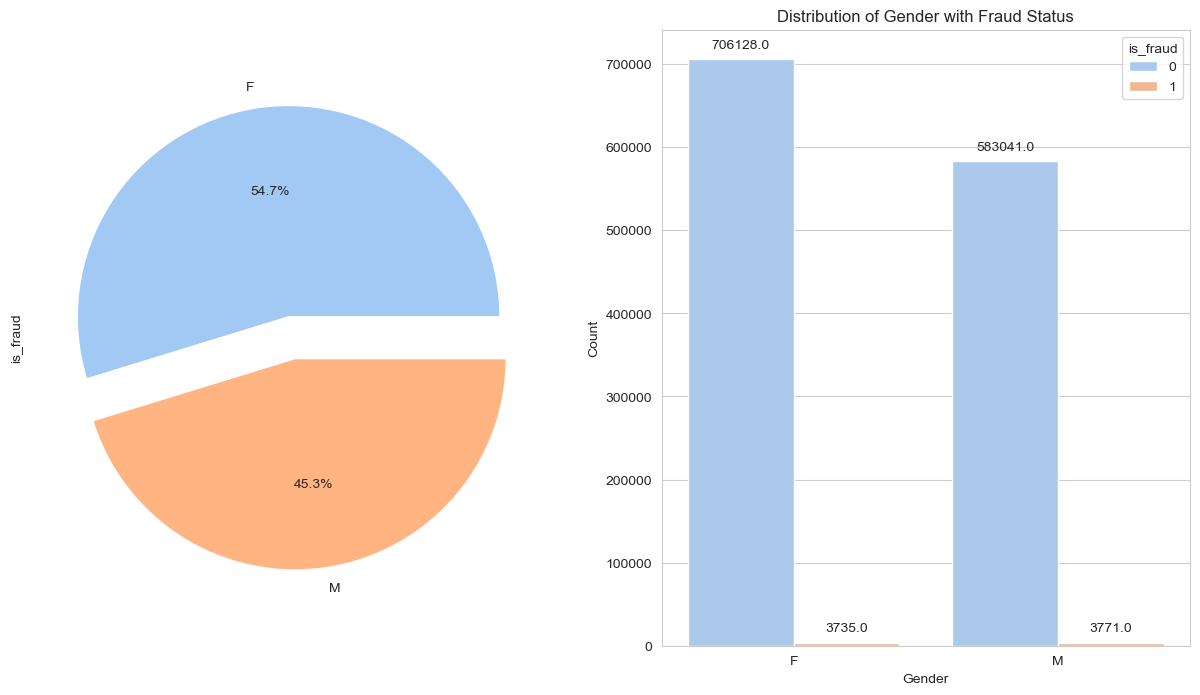

In [ ]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

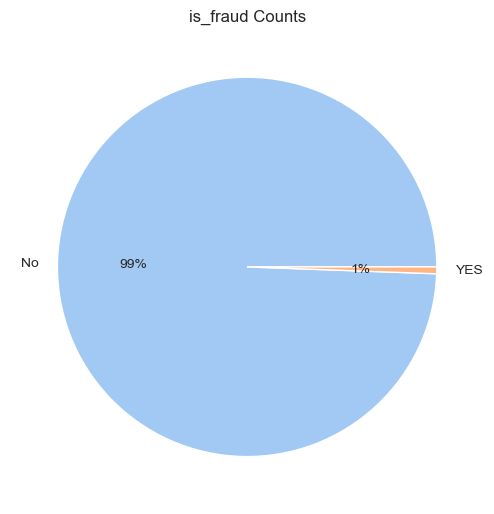

In [ ]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
# Changing 'trans_date_trans_time' to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# creating 'hour' and 'month'
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


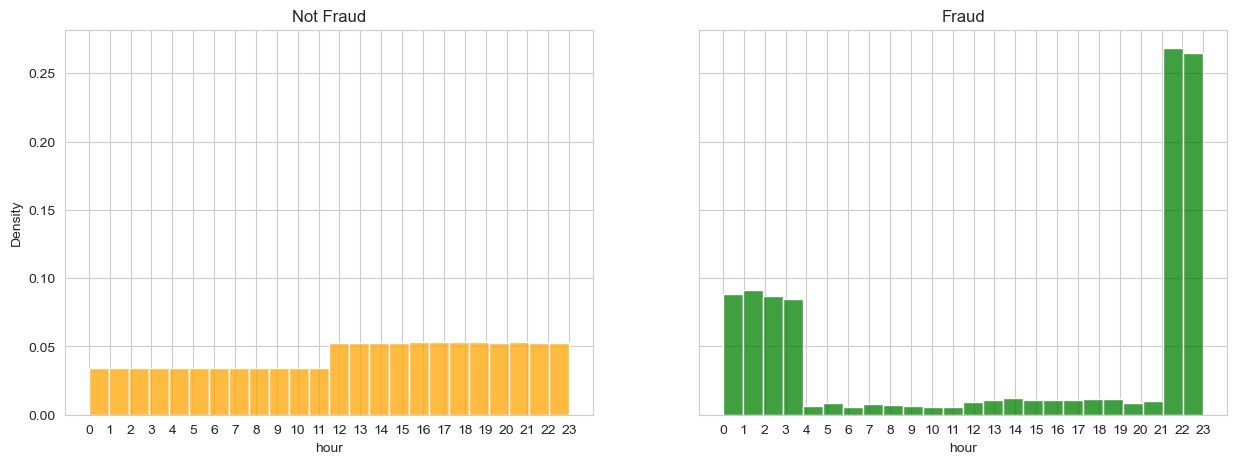

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

'hour' could be an important factor in predicting fradulent transactions

# Step 2. Pre-processing

In [ ]:
# remove non-useful columns for both test and train datasets
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [ ]:
# remove unnecessary string in both test and train datasets
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))
test_df['merchant'] = test_df['merchant'].apply(lambda x : x.replace('fraud_',''))

### Splitting the training dataset into train and validation dataset

In [ ]:
X=train_df.drop("is_fraud",axis=1)
y=train_df['is_fraud']

# train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_test=test_df.drop("is_fraud",axis=1)
y_test=test_df['is_fraud']

### Constructing a pipeline of WOEEncoder, StandardScaler, SMOTE (Oversampling)

In [ ]:
X_train.isna().sum()

merchant      0
category      0
amt           0
last          0
gender        0
lat           0
long          0
city_pop      0
job           0
merch_lat     0
merch_long    0
hour          0
month         0
dtype: int64

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import make_pipeline

In [ ]:
# mapping gender to 1, 0
def map_gender(X):
    if X['gender'].dtype in ['int64', 'float64']:
        return X  
    else: 
        X['gender'] = X['gender'].map({'F': 0, 'M': 1})
        return X

In [ ]:
# preprocessing
preprocessor=ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(),['amt','lat','long','city_pop','merch_lat','merch_long','hour','month']), # for numerical var
        ('categorical', WOEEncoder(),['merchant', 'category', 'last','job']), # for categorical var
    ], 
    remainder='passthrough'
    
)

In [ ]:
preprocessing_pipeline = make_pipeline(
    FunctionTransformer(map_gender),  
    preprocessor
)

In [ ]:
X_train =preprocessing_pipeline.fit_transform(X_train,y_train)

In [ ]:
smote=SMOTE(random_state=42)
X_train_s,y_train_s=smote.fit_resample(X_train,y_train)

## 1. Logistic Regression

In [ ]:
LR_model = LogisticRegression()
LR_model.fit(X_train_s,y_train_s)

LogisticRegression()

In [ ]:
# preprocessing validation dataset with pipeline
X_val_s=preprocessing_pipeline.transform(X_val)
predict_LR = LR_model.predict(X_val_s)

print(classification_report(y_val, predict_LR))
LR_accuracy = accuracy_score(predict_LR,y_val)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    257811
           1       0.05      0.76      0.09      1524

    accuracy                           0.91    259335
   macro avg       0.52      0.84      0.52    259335
weighted avg       0.99      0.91      0.95    259335

Logistic Regression accuracy is: 91.05%


## 2. Support Vector Machine Model (SVC)

In [ ]:
svm_model = LinearSVC()
svm_model.fit(X_train_s,y_train_s)
predict = svm_model.predict(X_val_s)

print(classification_report(y_val, predict))
svm_accuracy = accuracy_score(predict,y_val)
print('SVM accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    257811
           1       0.05      0.75      0.10      1524

    accuracy                           0.92    259335
   macro avg       0.53      0.84      0.53    259335
weighted avg       0.99      0.92      0.95    259335

SVM accuracy is: 91.05%


## 3. Gaussian Naive Bayes Model

In [ ]:
NB_model = GaussianNB()
NB_model.fit(X_train_s,y_train_s)
predict_naive = NB_model.predict(X_val_s)

print(classification_report(y_val, predict_naive))
GNB_accuracy = accuracy_score(predict_naive,y_val)
print('Gaussian Naive Bayes accuracy is: {:.2f}%'.format(GNB_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    257811
           1       0.04      0.74      0.08      1524

    accuracy                           0.91    259335
   macro avg       0.52      0.82      0.52    259335
weighted avg       0.99      0.91      0.95    259335

Gaussian Naive Bayes accuracy is: 90.56%


## 4. Decision Tree Model 

In [ ]:
# preprocessing validation dataset with pipeline
X_val_p=preprocessing_pipeline.transform(X_val)
DT_model = DecisionTreeClassifier(max_depth=5, random_state=42)
DT_model.fit(X_train_s,y_train_s)
predict_DT = DT_model.predict(X_val_p)

print(classification_report(y_val, predict_DT))
DT_accuracy = accuracy_score(predict_DT,y_val)
print('Decision Tree accuracy is: {:.2f}%'.format(DT_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    257811
           1       0.08      0.92      0.14      1524

    accuracy                           0.94    259335
   macro avg       0.54      0.93      0.56    259335
weighted avg       0.99      0.94      0.96    259335

Decision Tree accuracy is: 93.56%


## 5. Random Forest Classifier

In [ ]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=0)
RF_model.fit(X_train_s,y_train_s)
predict_RF = RF_model.predict(X_val_s)

print(classification_report(y_val, predict_RF))
RF_accuracy = accuracy_score(predict_RF,y_val)
print('Random Forest accuracy is: {:.2f}%'.format(RF_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257811
           1       0.87      0.78      0.82      1524

    accuracy                           1.00    259335
   macro avg       0.93      0.89      0.91    259335
weighted avg       1.00      1.00      1.00    259335

Random Forest accuracy is: 99.80%


## Model Selection

In [ ]:
Algorithms = ['RandomForest', 'Decision Tree', 'Logistic Regression', 'Support Vector Machine', 'Gaussian Naive Bayes']
accuracy = [RF_accuracy, DT_accuracy, LR_accuracy, svm_accuracy, GNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})
FinalResult

,Algorithm,Accuracy
0,RandomForest,0.998030
1,Decision Tree,0.935635
2,Logistic Regression,0.910540
3,Support Vector Machine,0.921970
4,Gaussian Naive Bayes,0.905555


In [ ]:
import joblib

In [ ]:
joblib.dump((DT_model,preprocessing_pipeline), 'new_decision_tree_model.joblib')

['new_decision_tree_model.joblib']

# FastAPI

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import Union
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from category_encoders import WOEEncoder
from datetime import datetime
import asyncio
import uvicorn

In [ ]:
model, preprocessing_pipeline=joblib.load("new_decision_tree_model.joblib")

In [99]:
api_title ="CreditCardFraudDetectionApp"
api_description="""
CreditCardFraudDetectionApp allows you to predict if a transaction is fraudulent or not.
"""
app=FastAPI(title=api_title,description=api_description)

class TransactionInput(BaseModel):
    merchant: str
    category: str
    amt: float
    last: str
    gender: str  
    lat: float
    long: float
    city_pop: int
    job: str
    merch_lat: float
    merch_long: float 
    hour: int
    month: int

class PredictOutput(BaseModel):
    is_fraud: bool
    probability: float   

@app.get("/")
def root():
    return "Hello! This is the credit card fraud prediction ML service!"

@app.post("/predict", response_model=PredictOutput)
def predict_fraud(transaction: TransactionInput):
    data = {
        'merchant': [transaction.merchant],
        'category': [transaction.category],
        'amt': [transaction.amt],
        'last': [transaction.last],
        'gender': [transaction.gender],
        'lat': [transaction.lat],
        'long': [transaction.long],
        'city_pop': [transaction.city_pop],
        'job': [transaction.job],
        'merch_lat': [transaction.merch_lat],
        'merch_long': [transaction.merch_long],
        'hour': [transaction.hour],
        'month': [transaction.month]
    }
    input_data = pd.DataFrame(data)
    
    input_data_processed=preprocessing_pipeline.transform(input_data)

    # predict
    prediction=model.predict(input_data_processed)
    probability=model.predict_proba(input_data_processed)[:,1]

    return PredictOutput(is_fraud=bool(prediction),probability=float(probability))



In [100]:
import nest_asyncio
nest_asyncio.apply()

In [101]:
async def run_server():
    await uvicorn.run(app, host="127.0.0.1", port=8000)

await run_server()

INFO:     Started server process [26316]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:50146 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:50146 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50146 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:50147 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [26316]


TypeError: object NoneType can't be used in 'await' expression